### Генерация поэзии с помощью нейронных сетей: шаг 1
##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

Ваша основная задача: научиться генерироват стихи с помощью простой рекуррентной нейронной сети (Vanilla RNN). В качестве корпуса текстов для обучения будет выступать роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина.

In [1]:
# do not change the code in the block below
# __________start of block__________
import string
import os
from random import sample

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output

import matplotlib.pyplot as plt
# __________end of block__________

In [2]:
# do not change the code in the block below
# __________start of block__________
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('{} device is available'.format(device))
# __________end of block__________

cuda device is available


#### 1. Загрузка данных.

In [3]:
# do not change the code in the block below
# __________start of block__________
!wget https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = "".join([x.replace('\t\t', '').lower() for x in text])
# __________end of block__________

--2024-11-01 20:07:01--  https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.009s  

2024-11-01 20:07:01 (28.7 MB/s) - ‘onegin.txt’ saved [262521/262521]



#### 2. Построение словаря и предобработка текста
В данном задании требуется построить языковую модель на уровне символов. Приведем весь текст к нижнему регистру и построим словарь из всех символов в доступном корпусе текстов. Также добавим токен `<sos>`.

In [16]:
# do not change the code in the block below
# __________start of block__________
tokens = sorted(set(text.lower())) + ['<sos>']
num_tokens = len(tokens)

assert num_tokens == 84, "Check the tokenization process"

token_to_idx = {x: idx for idx, x in enumerate(tokens)}
idx_to_token = {idx: x for idx, x in enumerate(tokens)}

assert len(tokens) == len(token_to_idx), "Mapping should be unique"

print("Seems fine!")


text_encoded = [token_to_idx[x] for x in text]
# __________end of block__________

Seems fine!


In [17]:
token_to_idx['<sos>']

83

__Ваша задача__: обучить классическую рекуррентную нейронную сеть (Vanilla RNN) предсказывать следующий символ на полученном корпусе текстов и сгенерировать последовательность длины 100 для фиксированной начальной фразы.

Вы можете воспользоваться кодом с занятие №6 или же обратиться к следующим ссылкам:
* Замечательная статья за авторством Andrej Karpathy об использовании RNN: [link](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* Пример char-rnn от Andrej Karpathy: [github repo](https://github.com/karpathy/char-rnn)
* Замечательный пример генерации поэзии Шекспира: [github repo](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)

Данное задание является достаточно творческим. Не страшно, если поначалу оно вызывает затруднения. Последняя ссылка в списке выше может быть особенно полезна в данном случае.

Далее для вашего удобства реализована функция, которая генерирует случайный батч размера `batch_size` из строк длиной `seq_length`. Вы можете использовать его при обучении модели.

In [5]:
# do not change the code in the block below
# __________start of block__________
batch_size = 256
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx['<sos>']

def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size*seq_length - 1)
    data = np.array(text_encoded[start_index:start_index + batch_size*seq_length]).reshape((batch_size, -1))
    yield np.hstack((start_column, data))
# __________end of block__________

Пример батча:

In [6]:
next(generate_chunk())

array([[83, 67,  1, ..., 53, 62, 63],
       [83, 45, 76, ..., 63, 47, 53],
       [83, 76,  1, ...,  0, 53,  1],
       ...,
       [83, 61, 76, ..., 58, 59,  1],
       [83, 62, 59, ..., 57,  7,  0],
       [83,  0,  0, ..., 53, 57, 50]])

In [11]:
next(generate_chunk()).shape

(256, 101)

In [13]:
f = next(generate_chunk())

Далее вам предстоит написать код для обучения модели и генерации текста.

In [15]:
import torch
import torch.nn as nn
import numpy as np

# Параметры
batch_size = 256
seq_length = 100
vocab_size = 84  # Замените на размер вашего словаря
embedding_dim = 128
hidden_dim = 256
num_layers = 2

# Определение RNN модели
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(input_size, input_size)
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq, hidden_state):
        embedding = self.embedding(input_seq)
        output, hidden_state = self.rnn(embedding, hidden_state)
        output = self.decoder(output)
        return output, (hidden_state[0].detach(), hidden_state[1].detach())

# Инициализация модели

def train():
    ########### Hyperparameters ###########
    hidden_size = 512   # size of hidden state
    seq_len = 100       # length of LSTM sequence
    num_layers = 3      # num of layers in LSTM layer stack
    lr = 0.002          # learning rate
    epochs = 100        # max number of epochs
    op_seq_len = 200    # total num of characters in output test sequence
    load_chk = False    # load weights from save_path directory to continue training
    save_path = "/content/onegin.pth"
    data_path = "/content/onegin.txt"
    #######################################

    # load the text file
    data = open(data_path, 'r').read()
    chars = sorted(list(set(data)))
    data_size, vocab_size = len(data), len(chars)
    print("----------------------------------------")
    print("Data has {} characters, {} unique".format(data_size, vocab_size))
    print("----------------------------------------")

    # char to index and index to char maps
    char_to_ix = { ch:i for i,ch in enumerate(chars) }
    ix_to_char = { i:ch for i,ch in enumerate(chars) }

    # convert data from chars to indices
    data = list(data)
    for i, ch in enumerate(data):
        data[i] = char_to_ix[ch]

    # data tensor on device
    data = torch.tensor(data).to(device)
    data = torch.unsqueeze(data, dim=1)

    # model instance
    rnn = RNN(vocab_size, vocab_size, hidden_size, num_layers).to(device)

    # load checkpoint if True
    if load_chk:
        rnn.load_state_dict(torch.load(save_path))
        print("Model loaded successfully !!")
        print("----------------------------------------")

    # loss function and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)

    # training loop
    for i_epoch in range(1, epochs+1):

        # random starting point (1st 100 chars) from data to begin
        data_ptr = np.random.randint(100)
        n = 0
        running_loss = 0
        hidden_state = None

        while True:
            input_seq = data[data_ptr : data_ptr+seq_len]
            target_seq = data[data_ptr+1 : data_ptr+seq_len+1]

            # forward pass
            output, hidden_state = rnn(input_seq, hidden_state)

            # compute loss
            loss = loss_fn(torch.squeeze(output), torch.squeeze(target_seq))
            running_loss += loss.item()

            # compute gradients and take optimizer step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update the data pointer
            data_ptr += seq_len
            n +=1

            # if at end of data : break
            if data_ptr + seq_len + 1 > data_size:
                break

        # print loss and save weights after every epoch
        print("Epoch: {0} \t Loss: {1:.8f}".format(i_epoch, running_loss/n))
        torch.save(rnn.state_dict(), save_path)

        # sample / generate a text sequence after every epoch
        data_ptr = 0
        hidden_state = None

        # random character from data to begin
        rand_index = np.random.randint(data_size-1)
        input_seq = data[rand_index : rand_index+1]

        print("----------------------------------------")
        while True:
            # forward pass
            output, hidden_state = rnn(input_seq, hidden_state)

            # construct categorical distribution and sample a character
            output = F.softmax(torch.squeeze(output), dim=0)
            dist = Categorical(output)
            index = dist.sample()

            # print the sampled character
            print(ix_to_char[index.item()], end='')

            # next input is current output
            input_seq[0][0] = index.item()
            data_ptr += 1

            if data_ptr > op_seq_len:
                break

        print("\n----------------------------------------")


train()

# Обучение модели
train_model(model, generate_chunk)


ValueError: Expected input batch_size (256) to match target batch_size (25344).

В качестве иллюстрации ниже доступен график значений функции потерь, построенный в ходе обучения авторской сети (сам код для ее обучения вам и предстоит написать).

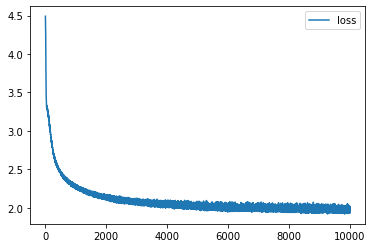

Шаблон функции `generate_sample` также доступен ниже. Вы можете как дозаполнить его, так и написать свою собственную функцию с нуля. Не забывайте, что все примеры в обучающей выборке начинались с токена `<sos>`.

In [ ]:
def generate_sample(char_rnn, seed_phrase=None, max_length=200, temperature=1.0, device=device):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''

    if seed_phrase is not None:
        x_sequence = [token_to_idx['<sos>']] + [token_to_idx[token] for token in seed_phrase]
    else:
        x_sequence = [token_to_idx['<sos>']]

    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)

    # Feed the seed phrase, if any
    char_rnn.eval()  # Устанавливаем модель в режим оценки
    generated_sequence = x_sequence.clone()  # Клонируем начальную последовательность для генерации

    with torch.no_grad():  # Отключаем градиенты
        for _ in range(max_length - len(x_sequence[[0]])):  # Генерируем до max_length
            output = char_rnn(generated_sequence)  # Прогоняем через модель
            output = output[:, -1, :]  # Берем последний выход (последний символ)

            # Применяем softmax для получения вероятностей
            probabilities = torch.softmax(output / temperature, dim=-1)

            # Генерируем следующий символ
            next_char_idx = torch.multinomial(probabilities, num_samples=1).item()

            # Добавляем следующий символ к последовательности
            generated_sequence = torch.cat((generated_sequence, torch.tensor([[next_char_idx]], dtype=torch.int64).to(device)), dim=1)

    return ''.join([tokens[ix] for ix in generated_sequence.cpu().data.numpy()[[0]]])

Пример текста сгенерированного обученной моделью доступен ниже. Не страшно, что в тексте много несуществующих слов. Используемая модель очень проста: это простая классическая RNN.

In [ ]:
print(generate_sample(model, ' мой дядя самых честных правил', max_length=500, temperature=0.8))

<sos> мой дядя самых честных правилас;



xiv

но как потокой.



xii

«я свобред не словавран в скорей,
для с посвялесь мне моловой,
те ты,
перегиной в тям праздной
и привезут перваю вся вновся сквозь ти стала сблился,
и старый свимарной таня обратель любова не когда и нет волностье нежной
тишен,
перестоком.
«поже постаничив очествы
в и старько забаньем и заковенью,
ее своя моднать наводушта;
какой нет поли своем горозный и быле и, законно он ходушних недважный плая
с за стра.



xvii




xxvi

все 


### Сдача задания
Сгенерируйте десять последовательностей длиной 500, используя строку ' мой дядя самых честных правил'. Температуру для генерации выберите самостоятельно на основании визуального качества генериуремого текста. Не забудьте удалить все технические токены в случае их наличия.

Сгенерированную последовательность сохрание в переменную `generated_phrase` и сдайте сгенерированный ниже файл в контест.

In [ ]:
seed_phrase = ' мой дядя самых честных правил'

In [ ]:
generated_phrases = # your code here

# For example:

# generated_phrases = [
#     generate_sample(
#         model,
#         ' мой дядя самых честных правил',
#         max_length=500,
#         temperature=1.
#     ).replace('<sos>', '')
#     for _ in range(10)
# ]

In [ ]:
# do not change the code in the block below
# __________start of block__________

import json
if 'generated_phrases' not in locals():
    raise ValueError("Please, save generated phrases to `generated_phrases` variable")

for phrase in generated_phrases:

    if not isinstance(phrase, str):
        raise ValueError("The generated phrase should be a string")

    if len(phrase) != 500:
        raise ValueError("The `generated_phrase` length should be equal to 500")

    assert all([x in set(tokens) for x in set(list(phrase))]), 'Unknown tokens detected, check your submission!'


submission_dict = {
    'token_to_idx': token_to_idx,
    'generated_phrases': generated_phrases
}

with open('submission_dict.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
print('File saved to `submission_dict.json`')
# __________end of block__________

На этом задание завершено. Поздравляем!